Taylor Manivanh

8/23/2022

AB Testing

[Tutorial](https://towardsdatascience.com/a-b-testing-a-complete-guide-to-statistical-testing-e3f1db140499)

# What is A/B testing?

A/B testing is one of the most popular controlled experiments used to optimize web marketing strategies. It allows decision makers to choose the best design for a website by looking at the analytics results obtained with two possible alternatives A and B.

**A/B Testing Methodology**
- Visitors of a website are randomly served with one of the two designs (A and B)
- Data about their activity is collected by web analytics
- Given this data, one can apply statistical tests to determine whether one of the two designs has better efficacy

**Website Efficacy**
Discrete metrics (aka binomial metrics) have only the two possible values of 0 and 1
- Click through rate: if a user is shown an advertisement, do they click on it?
- Conversion rate: If a user is shown an advert, do they convert into customers?
- Bounce rate: if a user visits a website, is the following visited page on the same website?

Continuous metrics (aka nonbinomial metrics) may take continuous values that are not limited to a set two discrete states
- Average revenue per user: how much revenue does a user generate in a month?
- Average session duration: how long does a user stay on a website in a session?
- Average order value: what is the total value of the order of a user?

**Statistical Significance**
- It is fundamental to determine how likely it is that the observed discrepancy between the two samples originates from chance.

In [2]:
# Import Statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.stats import chi2_contingency, mannwhitneyu, norm, t, ttest_ind

%matplotlib inline

## Two Sample Hypothesis Test
A two tailed test is a significance test in which alternative hypothesis has two ends. It determines that there is a relationship between variables in either direction. 

- Null Hypothesis: There is no significant difference between the efficacy of A and B
- Alternate Hypothesis: There is a significant difference between the efficacy of A and B
- p-value: is computed as the area under the two tails fo the probability density dunction (p(x)) of a chosen test statistic on all x's to p(x') <= p(our observation)
    - The computation of such p-value clearly depends on the data distribution

## 1. Discrete Metrics

Looking at click-though rate. We randomly show visitors one of two possible designs of an advertisement, and based on how many of them click on it we need to determine whether our data significantly contradict the hypothesis that the two designs are equivalently efficient.

In [3]:
np.random.seed(42)

x = np.random.binomial(n=1, p=0.6, size=15)
y = np.random.binomial(n=1, p=0.4, size=19)

_, (a, c) = np.unique(x, return_counts=True)
_, (b, d) = np.unique(y, return_counts=True)

df = pd.DataFrame(data=[[a, b], [c, d]], 
                 index=["click", "no click"], 
                 columns=["A", "B"])
m = df.values

print("- Observations:")
print(f"  - Version A: = {x}")
print(f"  - Version B: = {y}")
print("")
print("- Contingency table:")
display(df)

- Observations:
  - Version A: = [1 0 0 1 1 1 1 0 0 0 1 0 0 1 1]
  - Version B: = [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1]

- Contingency table:


,A,B
click,7,15
no click,8,4


- nX = 15 visitors saw the advertisement A, and 7 of them clicked on it.
- nY = 19 visitors saw the advertisement B, and 15 of them clicked on it.

Looks like B was more effective, but how statistically siginificant is this discrepancy?

### 1a. Fisher's Exact Test
**Fisher's Exact Test**: statistical significance test used in the analysis of contingency tables. It is used to examine the significance of the association (contingency) between the two kinds of classification. 
Since we have a 2x2 contingency table we can use Fisher's exact test to compute an exact p-value and test our hypothesis.


**Hypergeometric Distribution**: is a discrete probability distribution that describes the probability of *k* successes (random draws for which the object drawn has a specified feature) in *n* draws, without replacement, from a finite population of size *N* that contains exactly *K* objects with that feature, wherein each draw is either a success or a failure.

In [4]:
def hypergeom(k, K, n, N):
    """Probability mass funciton of the hypergeometric distribution."""
    return binom(K, k) * binom(N-K, n-k) / binom(N, n)


def fisher_prob(m):
    """Probability of a given observed contingency table according to Fisher's exact test."""
    ((a, b), (c ,d)) = m
    k = a
    K = a+b
    n = a+c
    N = a+b+c+d
    return hypergeom(k, K, n, N)

def fisher_probs_histogram(m):
    """Computes prob mass function histogram accroding to Fisher's exact test."""
    neg_val = -min(m[0,0], m[1,1])
    pos_val = min(m[1,0], m[1,0])
    probs = []
    for k in range(neg_val, pos_val+1):
        m1 = m + np.array([[1, -1], [-1, 1]]) * k
        probs.append(fisher_prob(m1))
    return probs

- Fisher's exact test: p-val = 7.5%


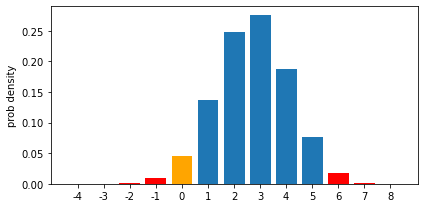

In [5]:
bars_h = np.array(fisher_probs_histogram(m))

f, ax = plt.subplots(figsize=(6, 3))
ii = np.arange(len(bars_h))
ax.bar(ii, bars_h)
idxs = bars_h <= fisher_prob(m)
ax.bar(ii[idxs], bars_h[idxs], color='r')
ax.set_ylabel("prob density")
p_val = bars_h[idxs].sum()
neg_val = -min(m[0,0], m[1,1])
pos_val = min(m[1,0], m[1,0])
ax.bar(ii[-neg_val], bars_h[-neg_val], color='orange')

ax.set_xticks(ii)
ax.set_xticklabels(np.arange(neg_val, pos_val+1))
f.tight_layout()
print(f"- Fisher's exact test: p-val = {100*p_val:.1f}%")

- the probability of seeing our actual observations is ~4.5%
- the probability of seeing even more unlikely observations in favor if B is ~1.0% (red left tail);
- the probability of seeing observations even more unlikely observations in favor if A is ~2.0% (red right tail).
- The Fisher's exact test gives p-value = ~7.5% (orange)

### 1b. Pearson's Chi Squared Test
**Pearson's Chi Squared Test**: A statistical test applied to sets of categorical data to evaluate how likely it is that any observed difference between the sets arose by chance. For large sample sizes, we can use Pearson's chi-squared test to compute an approximate p-value. 
- Moreover, if the observations are normally distributed, then the χ2 statistic follows exactly a chi-square distribution with 1 degree of freedom.
- In fact, this test can also be used with non-normal observations if the sample size is large enough, thanks to the central limit theorem.

In [6]:
chi2_val, p_val = chi2_contingency(m, correction=False)[:2]

print("- Pearson's chi-squared t-test:")
print(f"   - χ2 value: {chi2_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")

- Pearson's chi-squared t-test:
   - χ2 value: 3.825
   - p-value: 5.1%


## 2. Continuous Metrics
Let's consider average revenue per customer. We randomly show visitors one of two possible layouts of our website, and based on how much revenue each user generates in a month we want to determine if one of the two layouts is more efficient.

- Observations:
  - Version A: = [200 150 250 350 150 150 350 250 150 250 150 150 200   0   0 100  50]
  - Version B: = [300 150 150 400 250 250 150 200 250 150 300 200 250 200]

- Distribution plot:


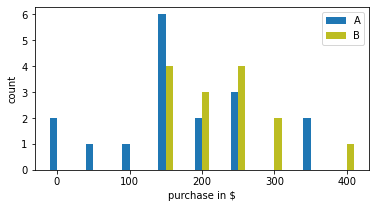

In [7]:
np.random.seed(42)

n_x, n_y = 17, 14

d1 = norm(loc=200, scale=100)
d2 = norm(loc=280, scale=90)

disc = 50
x = (d1.rvs(size=n_x) / disc).astype(int) * disc
y = (d2.rvs(size=n_y) / disc).astype(int) * disc


print("- Observations:")
print(f"  - Version A: = {x}")
print(f"  - Version B: = {y}")
print("")
print(f"- Distribution plot:")
f, ax = plt.subplots(figsize=(6, 3))
for i, (x_, l_, c_) in enumerate(zip([x, y], ["A", "B"], ["tab:blue", "tab:olive"])):
    v, c = np.unique(x_, return_counts=True)
    ax.bar(v-5+10*i, c, width=10, label=l_, color=c_)

ax.set_xlabel("purchase in $")
ax.set_ylabel("count")
ax.legend();

- nX = 17 users saw the layout A, and then made the following purchases: 

200$, 150$, 250$, 350$, 150$, 150$, 350$, 250$, 150$, 250$, 150$, 150$, 200$, 0$, 0$, 100$, 50$


- nX = 14 users saw the layout B, and then made the following purchases: 

300$, 150$, 150$, 400$, 250$, 250$, 150$, 200$, 250$, 150$, 300$, 200$, 250$, 200$

It looks like B was more effective but how statistically significant is this discrepancy?

### 2a. Z-test
**Z-test**: can be applied under the following assumptions

    - the observations are normally distributed (or the sample size is large)
    - the sampling distributions have known variance σX and σY
    
Under the above assumptions, the Z-test relies on the observation that the following Z statistic has a standard normal distribution.

In [8]:
def plot_pval(distribution, t_val, xlims=(-5, 5), ylims=(0, 0.5)):
    xxx = np.linspace(*xlims, 1000)
    f, ax = plt.subplots(figsize=(4,3))
    ax.plot(xxx, distribution.pdf(xxx))
    ax.set_ylim(ylims)
    ax.vlines(t_val, 0, stat_distrib.pdf(t_val), color='orange')
    ax.plot(t_val, stat_distrib.pdf(t_val), 'o', color='orange')
    xp = xxx <= t_val
    ax.fill_between(xxx[xp], xxx[xp] * 0, stat_distrib.pdf(xxx[xp]), color='r')
    xp = xxx >= -t_val
    ax.fill_between(xxx[xp], xxx[xp] * 0, stat_distrib.pdf(xxx[xp]), color='r')
    ax.set_ylabel("prob denisty")
    f.tight_layout()
    return f, ax

- Z-test:
   - z value: -1.697
   - p-value: 9.0%


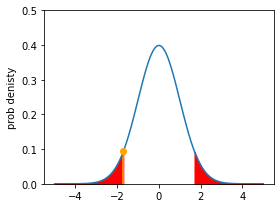

In [9]:
# Known standard deviations
s_x = 100
s_y = 90

# Z value
z_val = (x.mean() - y.mean()) / np.sqrt(s_x**2/n_x + s_y**2/n_y)

# Test statistic distribution under null hypothesis H0
stat_distrib = norm(loc=0, scale=1)

# p-value
p_val = stat_distrib.cdf(z_val) * 2

print("- Z-test:")
print(f"   - z value: {z_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_pval(stat_distrib, z_val);

Unfortunately in most real applications the standard deviations are unknown and must be estimated, so a t-test is preferable. If in our case we knew the true value of σX=100 and σX=90, then we would obtain:
- z ≈ -1.697
- which corresponds to a p-value ≈ 9%

### 2b. Student's T-Test
**Student's T-Test**: Can be applied under the following assumptions:

    - The observations are normally distributed (or the sample size is large)
    - The sampling distributions have "similar" variance σX ≈ σY


A t-test is the most commonly applied when the test statistic would follow a normal distribution if the value of a scaling term in the test statistic were known.  If the population variance is unknown (and therefore has to be estimated from the sample itself) and the sample size is not large (n < 30), the Student's t-test may be more appropriate over a Z-test.

- Student's t-test:
   - nu: 29.000
   - t value: -1.789
   - p-value: 8.4%


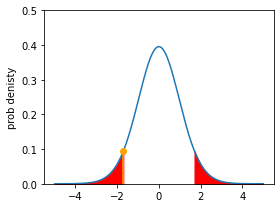

In [10]:
# Sample variances (w. Bessel correction)
s_x = np.sqrt(np.var(x, ddof=1))
s_y = np.sqrt(np.var(y, ddof=1))

# Pooled variance
s_p = np.sqrt(((n_x-1) * s_x**2 +
               (n_y-1) * s_y**2)
              / (n_x + n_y - 2))

# Test statistic distribution under null hypothesis H0
dofs = n_x + n_y - 2
stat_distrib = t(df=dofs, loc=0, scale=1)

# t value
t_val = (x.mean() - y.mean()) / (s_p * np.sqrt(1/n_x + 1/n_y))

# p-value
p_val = stat_distrib.cdf(t_val) * 2

print("- Student's t-test:")
print(f"   - nu: {dofs:.3f}")
print(f"   - t value: {t_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_pval(stat_distrib, z_val);

In our example, using Student’s t-test we obtain t ≈ -1.789 and ν = 29, which give p-value ≈ 8.4%.

### 2c. Welch's T-Test
**Welch's T-Test**: Can be applied under the same assumptions as a Student's T-Test but removes the requirement on similar variances:

    - The observations are normally distributed (or the sample size is large)

A slightly different t statistic is used, which also has the student distribution, but with different numbers of degrees of freedom. 

- Welch' t-test:
   - nu: 28.505
   - t value: -1.848
   - p-value: 7.5%


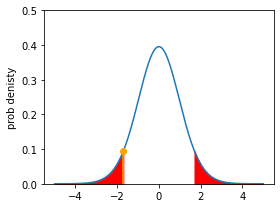

In [11]:
# Sample variances (w. Bessel correction)
s_x = np.sqrt(np.var(x, ddof=1))
s_y = np.sqrt(np.var(y, ddof=1))

# Denominator (not a pooled variance!)
s_d = np.sqrt(s_x**2/n_x + s_y**2/n_y)
    
    
# Test statistic distribution under null hypothesis H0
dofs = s_d**4 / ((s_x**2/n_x)**2/(n_x-1) +
                 (s_y**2/n_y)**2/(n_y-1))
stat_distrib = t(df=dofs, loc=0, scale=1)

# t value
t_val = (x.mean() - y.mean()) / s_d

# p-value
p_val = stat_distrib.cdf(t_val) * 2

print("- Welch' t-test:")
print(f"   - nu: {dofs:.3f}")
print(f"   - t value: {t_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_pval(stat_distrib, z_val);

In our example, using Welch’s t-test we obtain t ≈ -1.848 and ν ≈ 28.51, which give p-value ≈ 7.5%.

## 3. Continuous Non-Normal Metrics
For continuous metrics we assumed that the observations came from normal distributions. But non-normal distributions are extremely common when dealing with per user revenue 

Here are ways that normality is often violated:

    - zero_inflated_distributions: most users don't buy anything at all, so there are a lot of zero observations
    - multimodal distributions: a market segment tends to purchase cheap products, while another segment purchases more expensive products
    
Thanks to the central limit theorum, the distribution of the test statistics tend to normality as the sample sizes increase.

But if sample sizes are too small to assume normality, we have to use non-parametric approaches such as the Mann-Whitney U Test

### 3a. Mann-Whitney U Test
**Mann-Whitney U Test**: Makes no assumption of the nature of sampling distributions, so it is fully nonparametrics. The idea of the test is to compute theU statistic.

The values of this test statistic are tabulated, as the distribution can be computed under the null hypothesis that, for random samples X and Y from the two populations, the probability P(X < Y) is the same as P(X > Y).

In [13]:
mwu = mannwhitneyu(x, y, use_continuity=False, alternative="two-sided")

print("- Mann-Whitney U test:")
print(f"   - U value: {mwu.statistic:.3f}")
print(f"   - p-value: {mwu.pvalue*100:.1f}%")

- Mann-Whitney U test:
   - U value: 76.000
   - p-value: 8.0%


In our example, using Mann-Whitney U test we obtain u = 76 which gives p-value ≈ 8.0%.

## 4. Data Distribution vs Stats Distribution
Tests that rely on the assumption of normally distributed test statistics can also be applied if the original sampling distribution is highly non-normal!

Indeed, thanks to the Central Limit Theorem, the distribution of the test statistic is asymptotically normal as the sample size increases.

This is very useful in the common case of A/B tests that produce observations that are zero-inflated and/or multimodal.

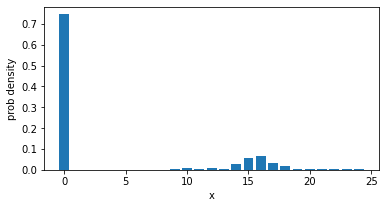

In [14]:
p = np.array([245, 0, 0, 0, 0, 0, 0, 0, 0,  1, 3, 1, 3, 2, 9, 18, 22, 10, 6, 2, 2, 1, 2, 1, 1])
a = np.arange(len(p))
p = p / p.sum()

f, ax = plt.subplots(figsize=(6, 3))
ax.bar(a, p)
ax.set_ylabel("prob density")
ax.set_xlabel("x");

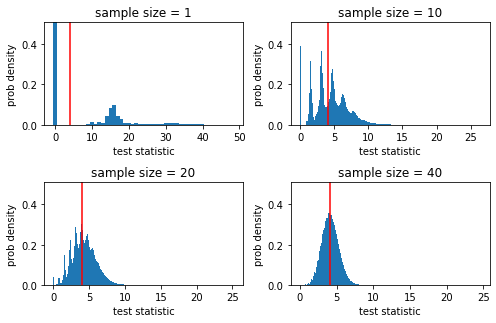

In [15]:
loc = (p*np.arange(len(p))).sum()

nn = [1, 10, 20, 40]
f, axx = plt.subplots(2, 2, figsize=(3.5*2, 2.3*2))    

for i, n in enumerate(nn):
    r, c = divmod(i, 2)        
    x = p
    ax = axx[r, c]
    for _ in range(n):
        x = np.convolve(x, p)

    ax.bar(np.arange(len(x))/n, x*n, width=1/n)
    ax.set_ylim([0, 0.51])
    ax.vlines(loc, 0, 0.51, 'r')
    ax.set_xlabel("test statistic")
    ax.set_ylabel("prob density")
    ax.set_title(f"sample size = {n}")

f.tight_layout()

# Statistical Tests for computing the significance of AB Tests

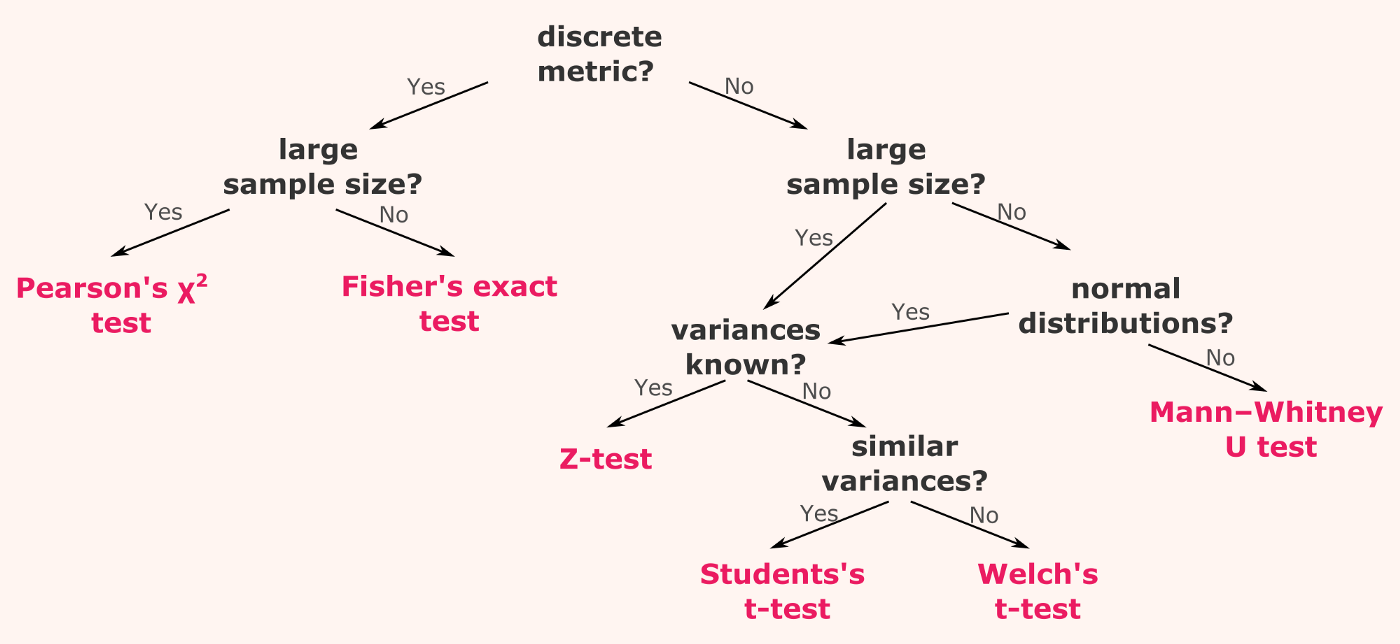